In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from diffractio import np, sp, plt, nm, um, mm, degrees

from diffractio.scalar_masks_XY import Scalar_mask_XY
from diffractio.scalar_sources_XY import Scalar_source_XY
from diffractio.vector_masks_XY import Vector_mask_XY
from diffractio.vector_sources_XY import Vector_source_XY

number of processors: 8
total memory        : 15.5 Gb
available memory    : 57 %
max frequency       : 3100 GHz


In [3]:
from py_pol.jones_matrix import Jones_matrix
from py_pol.jones_vector import Jones_vector

In [4]:
from py_aocg.SLM_system import cargar_Jones_SLM, SLM_system_field
from py_aocg.ifta.algorithms import distances_scalar, distances_vector

py_aocg
number of processors: 8
total memory        : 15.5 Gb
available memory    : 56 %
max frequency       : 3100 GHz


## Cargar Matrices de polarización de Holoeye

In [5]:
S_incident=Jones_vector('incident')
S_incident.linear_light(azimuth=45*degrees)

incident = 
[+0.707+0.000j ]   
[+0.707+0.000j ]   

In [6]:
Jslm=cargar_Jones_SLM(type="Jones")

## Ejemplo de sistema sin polarizadores

In [7]:
##Interesantes
# angles=np.array((0,45*degrees,0,90*degrees))


In [88]:
# Hay que normalizar las amplitudes

angles=np.array((np.nan, np.nan, np.nan, np.nan))
amplitude, phase, fields=SLM_system_field(angles, Jslm, E0=S_incident)

#TODO Jesús: No funciona el normalize intensity
#fields.normalize(kind='intensity') ## no funciona
#fields.normalize(kind='amplitude')

amplitude = amplitude / amplitude.max()

Es_posible = amplitude*np.exp(1j*phase)

## Captura de campos fabricables

In [89]:
Esx_posible,Esy_posible=fields.parameters.components()

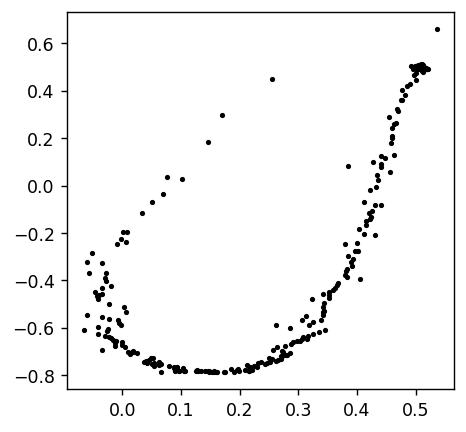

In [90]:
plt.plot(np.real(Esx_posible), np.real(Esy_posible), 'k.', ms=4)

The intensity of J * J * J * J * J * incident is (a.u.):
The mean value is 0.6870397785622885 +- 0.13639278364288518


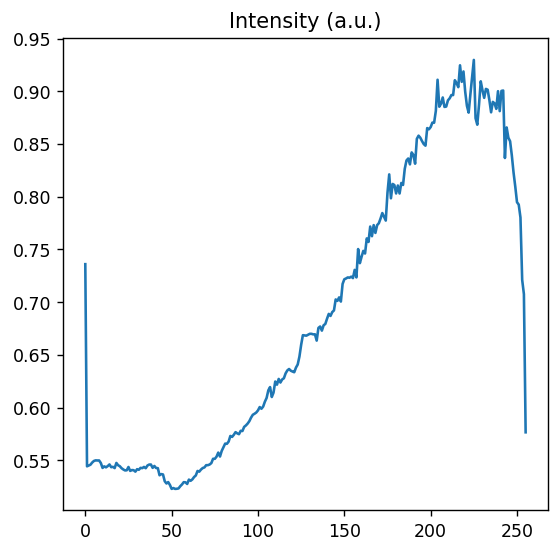


Delay between electric field components of J * J * J * J * J * incident is (deg.):
The mean value is 151.8480917447977 +- 106.74198810883826


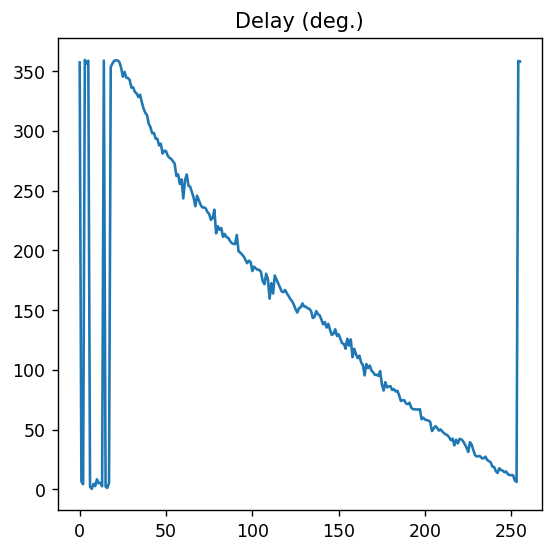

In [95]:
intensity = fields.parameters.intensity(draw=True)
phase = fields.parameters.delay(draw=True)

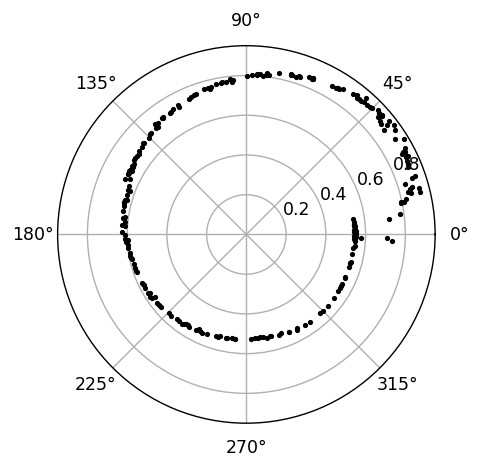

In [96]:
#TODO: Jesus al normalizar la intensidad cambiar la forma, no es normal
plt.polar(phase, intensity, 'k.', ms=4)

## Distancias entre campo vectorial y fabricable
Estamos en modo escalar. Queremos calcular las distancias entre un campo complejo [$A_x(x,y)e^{i \phi_x(x,y)}$,  $A_y(x,y)e^{i \phi_y(x,y)}$] -y unos elementos fabricables [$A_xf(x,y)e^{i \phi_xf(x,y)}$, $A_y f(x,y)e^{i \phi_yf(x,y)}$]. Pasamos a campos Er y Ei pues es más sencillo medir distancias

## NxMx4

 - DOE representa los vectores de stokes de la imagen (DOE) NxM. El 4 representa $(E_x^r, E_x^i, E_y^r, E_y^i)$ 
 - S_posible representa las posibles soluciones que en este caso son 6


In [11]:
def distances_vector_backup(DOEx, DOEy, Esx_posible, Esy_posible):
    """Vector distances between a N x M complex field given by (DOEx, DOEy) and the manufacturable fields K complex

    Arguments:
        DOEx (np.array complex): NxM complex array with desired DOE
        DOEy (np.array complex): NxM complex array with desired DOE
        Esx_posible (np.array complex): K complex array with fabricable fields
        Esy_posible (np.array complex): K complex array with fabricable fields

    Returns:
        DOE_new_x (np.array complex): NxM complex array with fabricable positions
        DOE_new_y (np.array complex): NxM complex array with fabricable positions
        i_positions (np.array int): NxM int array with selected positions
        distances (np.array float): NxM minimum distances between DOE and Es_posible

    """
    
    DOEx_r = np.real(DOEx)
    DOEx_i = np.imag(DOEx)
    DOEy_r = np.real(DOEy)
    DOEy_i = np.imag(DOEy)
    
    Efx_r = np.real(Esx_posible)
    Efx_i = np.imag(Esx_posible)
    Efy_r = np.real(Esy_posible)
    Efy_i = np.imag(Esy_posible)
    
    x1=np.stack((DOEx_r,DOEx_i, DOEy_r, DOEy_i),axis=2)
    x2=np.stack((Efx_r, Efx_i, Efy_r, Efy_i), axis=1)
    distance = (x1[np.newaxis,:,:,:]-x2[:,np.newaxis, np.newaxis, :])**2
    distances=np.sqrt(distance.sum(axis=3))
    distances_min = distances.min(axis=0) 
    i_mins=(distances==distances_min)
    i_positions=np.argmax(i_mins, axis=0)
    DOE_new_x=np.zeros_like(i_positions,dtype=complex)
    DOE_new_y=np.zeros_like(i_positions,dtype=complex)
    for i, Ex_posible in enumerate(Esx_posible):
        DOE_new_x[i_positions==i]=Ex_posible
        DOE_new_y[i_positions==i]=Esy_posible[i]

    return DOE_new_x, DOE_new_y, i_positions, distances

## Target

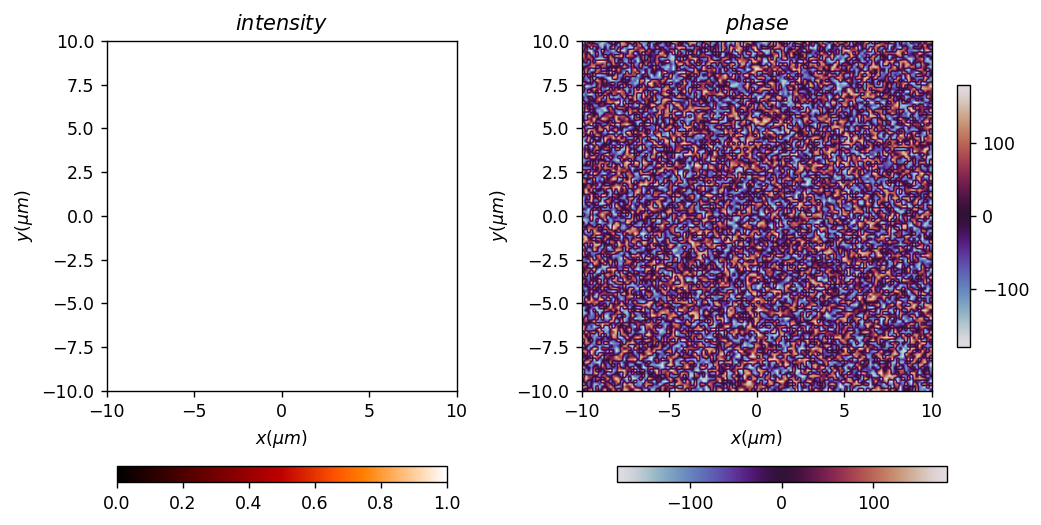

In [12]:
num_x=128
num_y=128
DOE_size=20*um

x=np.linspace(-DOE_size/2,DOE_size/2, num_x)
y=np.linspace(-DOE_size/2,DOE_size/2, num_y)
wavelength=0.6328*um

source=Scalar_source_XY(x,y,wavelength)
source.plane_wave()



target=Scalar_mask_XY(x,y,wavelength)
target.circle(r0=(0,0), radius=(1,1), angle=0)
target.roughness(.1,0.25)
target.draw('field',has_colorbar='vertical');

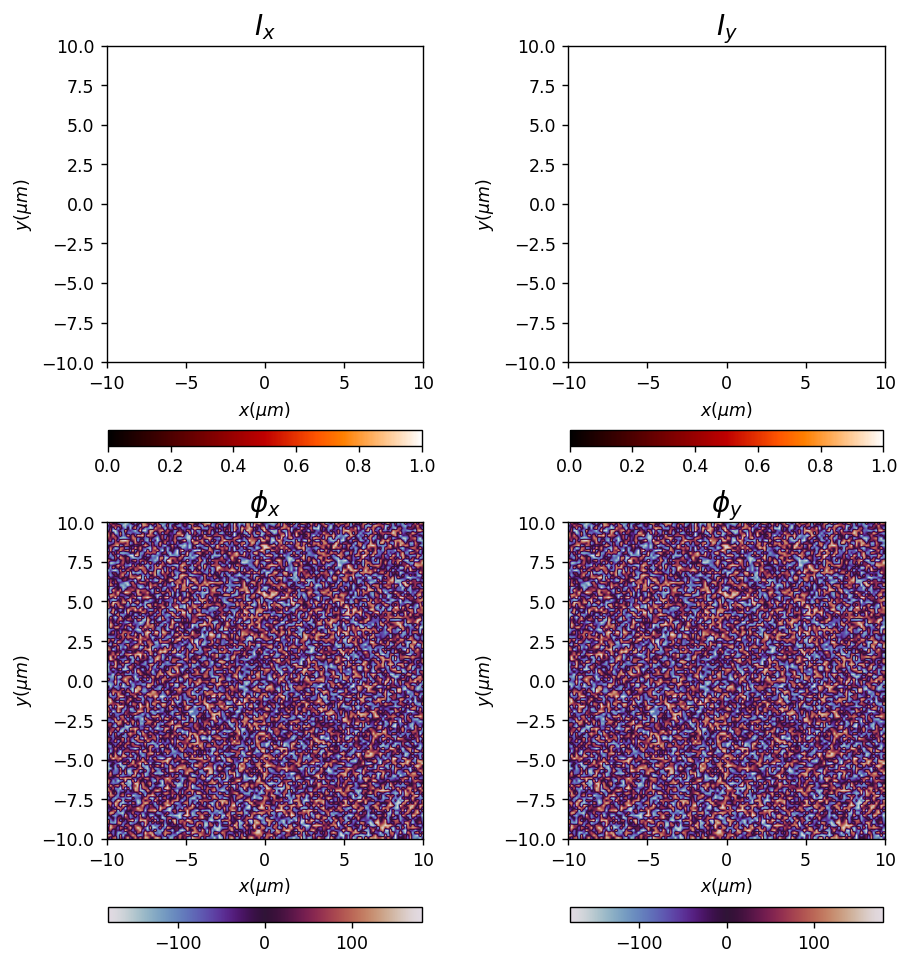

In [13]:
vtarget=Vector_source_XY(x,y,wavelength)
vtarget.constant_wave(u=target, v=(1,1), has_normalization=True)
vtarget.draw('fields');

## Algoritmo

Aquí intentamos el algortimo de GS para optimizar la intensidad con el campo vectorial

In [25]:
DOEu = vtarget.IVFFT(matrix=True, radius=100, focal=100)
DOE_x=DOEu[:,:,0]
DOE_y=DOEu[:,:,1]

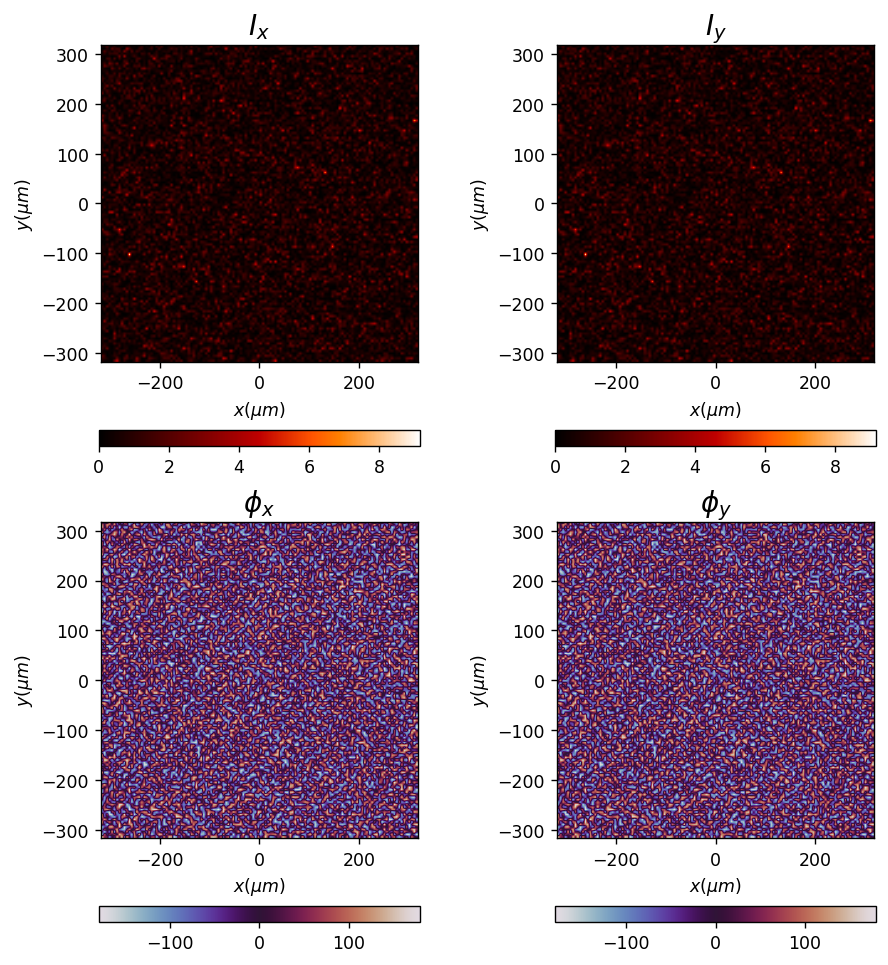

In [26]:
DOE_f = vtarget.IVFFT(new_field=True, radius=100, focal=100)
DOE_f.draw('fields');

CPU times: user 261 ms, sys: 36.1 ms, total: 297 ms
Wall time: 296 ms


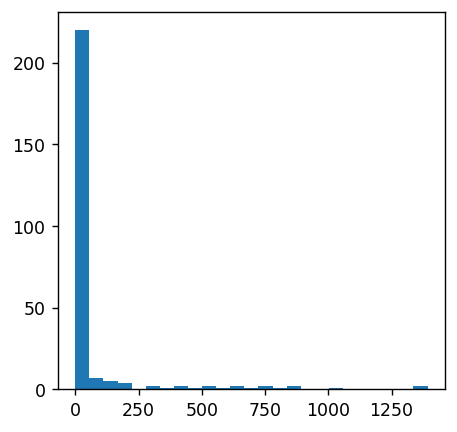

In [104]:
%%time
DOE_new_x, DOE_new_y, i_positions, distances=distances_vector(DOE_x, DOE_y, Esx_posible, Esy_posible, True)

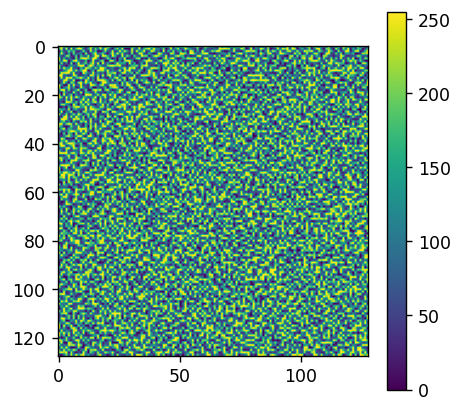

In [43]:
plt.imshow(i_positions)
plt.colorbar()

In [48]:
distances.mean()

0.8084948782498902

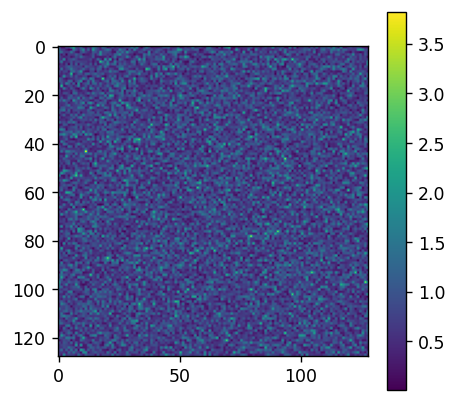

In [47]:
plt.imshow(distances)
plt.colorbar()

In [28]:

def VGS_far_algorithm(source, target, num_steps, has_draw=False):
    """Gerbech-Saxton algorithm for the far field.

    Arguments:
        source (None or Scalar_field_XY): Illumination.
        target (Scalar_mask_XY): Objective.
        num_steps (int): number of steps in the algorithm
        has_draw (bool): If True, draws the errors.

    Returns:
        mask_final (Scalar_mask_XY): Result mask of algorithm.
        errors (np.array): Data of errors
    """

    errors = np.zeros(num_steps)

    z = 1 * mm
    x = target.x
    y = target.y
    num_x = len(x)
    num_y = len(y)
    wavelength = target.wavelength


    if source is None:
        source = Scalar_source_XY(x, y, wavelength)
        source.plane_wave()

    DOE = Scalar_mask_XY(x, y, wavelength)
    far_field = Scalar_mask_XY(x, y, wavelength)

    target_abs = np.fft.fftshift(np.abs(target.u))
    far_field.u = target_abs * np.exp(
        1j * 2 * np.pi * np.random.rand(num_y, num_x))
    I_result = target_abs**2
    I_result_mean = I_result.mean()

    for i in range(num_steps):
        print("{}/{}".format(i, num_steps), end='\r')
        DOE = far_field.ifft(z=z, shift=False)
        mask = np.angle(DOE.u)
        DOE.u = np.exp(1j * mask)
        field_z = DOE.fft(z=z, shift=False, matrix=True)
        I_z = np.abs(field_z)**2
        I_z = I_z * I_result_mean / I_z.mean()
        far_field.u = target_abs * np.exp(1j * np.angle(field_z))

        error = nmse(I_result, I_z)
        print("{}/{} - error {:2.6f}".format(i, num_steps, error), end='\r')
        errors[i] = error

    if has_draw:
        plt.figure()
        plt.imshow(I_result)
        plt.colorbar()
        plt.figure()
        plt.imshow(I_z)
        plt.colorbar()

        
        plt.figure()
        plt.plot(errors, 'k', lw=2)
        plt.xlabel('# step')
        plt.ylabel('error')
        plt.title('optimization')
        plt.ylim(ymin=0)

    mask = np.fft.fftshift(mask)
    mask = (mask + np.pi) / (2 * np.pi)

    mask_final = Scalar_mask_XY(x, y, wavelength)
    mask_final.u = mask

    return mask_final, errors
